# FinBert
```
Env: python 3.11.5 (conda sentiment)
transformer: pip install transformers[sentencepiece]
```

## 1. Import / Data

### 1.1 Import

In [2]:
%load_ext autoreload
%autoreload 2'
import matplotlib.pyplot as plt
import torch, gc, sys
import pandas as pd
import numpy as np
import transformers
import warnings
import json
from scipy.stats.mstats import winsorize
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, pipeline, AdamW,\
    get_linear_schedule_with_warmup, BertConfig
from transformers import LongformerTokenizer, LongformerForSequenceClassification
from torch.nn.functional import softmax
warnings.filterwarnings("ignore")
transformers.__version__

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'4.27.0.dev0'

### 1.2 Data Preprocess

In [3]:
from utils import *
"""
from utils import get_cpu_usage, get_ram_usage, trans
from utils import prc_data
from utils import get_text_data
from utils import text_concatenate_diff_data
from utils import text_concatenate_diff_data
from utils import merge_prc_text, text_concatenate_within_same_date, process_time
"""

'\nfrom utils import get_cpu_usage, get_ram_usage, trans\nfrom utils import prc_data\nfrom utils import get_text_data\nfrom utils import text_concatenate_diff_data\nfrom utils import text_concatenate_diff_data\nfrom utils import merge_prc_text, text_concatenate_within_same_date, process_time\n'

In [4]:
# texts data: 2409 => anue_2409_20231208to20211224
# texts data: 友達 => anue_友達_20231215to20221227
# texts data: 面板 => anue_面板_20231216to20230412
data_1 = get_text_data("anue_2409_20231208to20211224")
data_2 = get_text_data("anue_友達_20231215to20221227")
data_3 = get_text_data("anue_面板_20231216to20230412")

# to dict
data_1 = data_1.set_index(["time"])["content"].to_dict()
data_2 = data_2.set_index(["time"])["content"].to_dict()
data_3 = data_3.set_index(["time"])["content"].to_dict()

stock = "2409.TW"
list_of_data = [data_2, data_3]
data = text_concatenate_diff_data(list_of_data)
prc = prc_data(stock)
data = process_time(prc, data)
data = text_concatenate_within_same_date(data)
prc_text = merge_prc_text(prc, data).rename(columns={'content': 'stock'})
prc_text.reset_index(inplace=True)

[*********************100%%**********************]  1 of 1 completed
duplicated time: 0


### 1.3 Text Len Check
```no need to run```

Check if text length too long for finber

In [9]:
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

In [11]:
prc_text = prc_text
scores = dict()
score = 0

# check the tokens >= 512?
for index, (time, content) in prc_text[["time", "content"]].iterrows():
    if str(content) == "nan":
        scores[time] = score
    else:
        try:
            content = content.split("\n")
            inputs = tokenizer(content, return_tensors="pt", padding=True)
            outputs = finbert(**inputs)[0]
        except:
            print("text too long")
            break


text too long


## 2. PRETRAINED MODEL
- [Transformer](https://huggingface.co/docs/transformers/index)
- [Tokeniser Doc](https://huggingface.co/docs/transformers/main_classes/tokenizer)
- [Model Lists Transformers](https://huggingface.co/docs/transformers/main_classes/model)
- Long Document Solution
    - Chunks
    - Longformer - need fine tune\
        Wanrings
        ```
        Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']

        You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
        ```
    - Longformer encode decoder
    

In [5]:
# Model
model_name = 'yiyanghkust/finbert-tone'
revision = "main"
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
summarise = pipeline("summarization")

# Load pre-trained Longformer model and tokenizer
model_name = "allenai/longformer-base-4096"  # You can choose a different Longformer model
longformer = LongformerForSequenceClassification.from_pretrained(model_name)
'tokenizer_long = LongformerTokenizer.from_pretrained(model_name)'

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequ

'tokenizer_long = LongformerTokenizer.from_pretrained(model_name)'

### 2.2 Get Scores for Stock Data


In [ ]:

dictfilename = f"result\\{stock}.json"
json_file = open(dictfilename, 'w', encoding='utf-8')

# scores: {time: returns, score_date, content, long_text}
scores = dict()

score_date = torch.tensor([0., 0., 0.]) 
for index, (time, returns, content) in prc_text[["time", "return", "stock"]].iterrows():
    gc.collect()

    
    try:
        print("="*70)
        print(f"Sentiment for {time}")
        print(f"CPU Usage: {get_cpu_usage()}%")
        print(f"RAM Usage: {get_ram_usage()}%")

        # if no content set the date's score to be last date's score
        if str(content) == "nan":
            print(f"no text today")
            score_date = None
            long_text = None
            scores[str(time)] = [returns, score_date, content, long_text]

        # if have content, get the score from model        
        else:

            # seperate content for different news
            content = content.split("\n")        
            content = trans(content)

            # finbert
            try:
                long_text = False
                # if the content short enough, get the score directly
                inputs = tokenizer(content, return_tensors="pt", padding=True) 
                print(inputs["input_ids"].shape)
                outputs = finbert(**inputs)[0][:, 1:]
                
            # use longformer if the content is too long                
            except:
                print("Required for Longformer")
                long_text = True

                inputs = tokenizer(content, return_tensors="pt", padding=True)
                outputs = longformer(**inputs).logits[:, [1, 0]]
            
            # scores for each date
            score_date = softmax(torch.sum(outputs, dim=0))

            # scores 
            scores[str(time)] = [returns, score_date.tolist(), content, long_text]

            
        print(f'scroes: {score_date}')
    except:
        print(f'Error scoring at {time}')
    

dictfilename = f"result\\{stock}.json"
json_file = open(dictfilename, 'w')
line = json.dumps(scores, ensure_ascii=False, indent=1) + "\n"
json_file.write(line)
json_file.close()
    




### 2.3 Backtest

In [ ]:
stock = '2409.TW'
dictfilename = f"result\\{stock}.json"
with open(dictfilename, 'r', encoding='utf_8') as json_file:
    # {time: returns, score_date, content, long_text}
    result = json.load(json_file)

score_history = []
return_history = []
time_history = []
for k, i in zip(list(result.keys()), list(result.values())):
    try:
        print(i[1])
        s = (i[1][0] + (-1)*i[1][1])#.detach().numpy()
        score_history.append(s)
        return_history.append(i[0])
        time_history.append(k)
    except:
        pass

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.005
Model:                            OLS   Adj. R-squared (uncentered):              0.001
Method:                 Least Squares   F-statistic:                              1.194
Date:                Mon, 25 Dec 2023   Prob (F-statistic):                       0.276
Time:                        17:18:19   Log-Likelihood:                          597.23
No. Observations:                 232   AIC:                                     -1192.
Df Residuals:                     231   BIC:                                     -1189.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

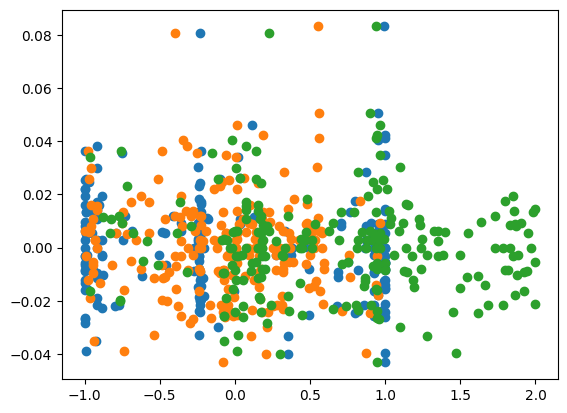

In [162]:
from utils import *
import statsmodels.api as sm
plt.scatter(score_history, return_history)
linear = sm.OLS(return_history, score_history).fit()
print(linear.summary())

# Calculate the moving average with a window size of 10
window_size = 3
smoothed = moving_average(score_history, window_size)
linear = sm.OLS(return_history[window_size-1:], smoothed).fit()
plt.scatter(smoothed, return_history[window_size-1:])
print(linear.summary())

# Calculate the exponential of 2 moving average with a window size of 3
alpha = .8
window_size = 2
exp_smoothed = exp_moving(score_history, window_size)
linear = sm.OLS(return_history[window_size-1:], exp_smoothed).fit()
plt.scatter(exp_smoothed, return_history[window_size-1:])
print(linear.summary())

In [125]:
return_history = return_history[window_size-1:]
len(return_history), len(exp_smoothed)

In [163]:
determinant_senti = score_history

In [164]:
from numpy import std
buy = 0
count_buy = 0
count_sell = 0
sell = 0
neutral = 0
state = ""
scores = []
senti_last_day = 0
senti_mean = np.mean(determinant_senti)
senti_std = np.std(determinant_senti)
sell_history = []
buy_history = []
for (senti, returns) in zip(determinant_senti, return_history):
    scores_mean = np.mean(scores)
    if  senti >= (senti_mean + senti_std):
        count_buy += 1
        if state != "buy":
            print('Switch to buy')
            buy += (returns - 0.004)
            state = "buy"
        else:
            buy += returns
    elif senti < (senti_mean - senti_std):
        print('Switch to sell')
        count_sell += 1
        if state != "sell":
            sell += (returns - 0.004)
            state = "sell"
        else:
            sell += returns
    else:
        state = "None"
    senti_last_day = senti
    buy_history.append(buy)
    sell_history.append(sell)
print(f"N positive: {count_buy}; N negative: {count_sell}")
print(f"buy with positive: {buy}")
# print(f"buy with predicted return between +(-)0.004: {neutral}")
print(f"buy with negative: {sell}")
print(f"buy all: {sum(return_history)}")

Switch to sell
Switch to sell
Switch to sell
Switch to sell
Switch to sell
Switch to sell
Switch to sell
Switch to sell
Switch to sell
Switch to sell
Switch to sell
Switch to buy
Switch to buy
Switch to buy
Switch to buy
Switch to sell
Switch to sell
Switch to sell
Switch to sell
Switch to sell
Switch to buy
Switch to sell
Switch to sell
Switch to buy
Switch to buy
Switch to sell
Switch to sell
Switch to sell
Switch to sell
Switch to sell
Switch to sell
Switch to sell
Switch to sell
Switch to sell
Switch to sell
Switch to buy
Switch to sell
Switch to sell
Switch to sell
Switch to sell
Switch to sell
Switch to sell
Switch to sell
Switch to sell
Switch to buy
Switch to sell
Switch to buy
Switch to buy
Switch to buy
Switch to sell
Switch to sell
Switch to buy
Switch to buy
Switch to sell
Switch to buy
Switch to sell
Switch to buy
Switch to buy
Switch to buy
Switch to buy
Switch to buy
Switch to buy
Switch to sell
Switch to buy
Switch to buy
Switch to sell
Switch to buy
Switch to sell
Swit

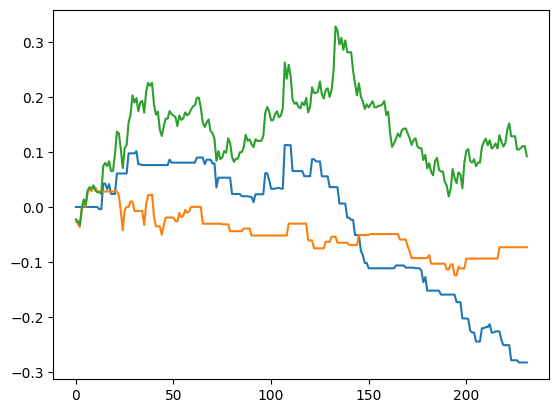

In [165]:
plt.plot(buy_history)
plt.plot(sell_history)
plt.plot(np.cumsum(return_history))

# 3. FINETUNE
- Finbert
    - Cannot Finetune: The length of tokens over 512. Finetune the model needs padding all input to same length
    - Possible Solution for this
        - Chunk test
- Longformer
    - Finetuning Longformer
    - Finetune by Finbert tokenizer


###  3.1 Data

Split data

In [ ]:
from_date = pd.to_datetime("2022-07-01").tz_localize("Asia/taipei")
end_date = pd.to_datetime("2023-04-30").tz_localize("Asia/taipei")
val_from_date = pd.to_datetime("2023-05-01").tz_localize("Asia/taipei")
val_end_date = pd.to_datetime("2023-08-10").tz_localize("Asia/taipei")

time_val = pd.Timestamp(2023, 2, 1)
time_test = pd.Timestamp(2023, 5, 1)
data_train = data_all[data_all["time"] <= time_val]
data_val = data_all[(data_all["time"] >= time_val) & (data_all["time"] <= time_test)]
data_test = data_all[data_all["time"] >= time_test]

Translate data\
`Don't run this section`

In [ ]:
"""
In pretrained model, decide the scores for each articles and add the scores together
for those in the same date. In finetuning, since we are going to get the sum of the 
influence of each artclie for a single day, we do not regard the unit as article but
all articles in the same day.
"""
import pickle
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
texts_name = 'stock'
len_tokens = []
not_work_time = []
trans_ret_data = {}


for index, (time, returns, content) in prc_text[["time", "return", texts_name]].iterrows():
    try:
        trans_content = trans([content])
        trans_ret_data[time] = [returns, trans_content]
    except:
        print('error')
        print(content)
        not_work_time.append(time)


with open("_temp/trans_data.pk", "wb") as f:
    pickle.dump(trans_ret_data, f)
not_work_time

Load translated data

In [ ]:
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
with open("_temp/trans_data.pk", "rb") as f:
    trans_ret_data = pickle.load(f)

trans_ret_data= pd.DataFrame(trans_ret_data).transpose().reset_index()
trans_ret_data.columns = ['time', 'returns', 'trans']
trans_ret_data.set_index('time', inplace=True)
trans_ret_data


Check if all length is 1

In [86]:
# check if all length == 1
for i in list(trans_ret_data['trans']):
    if len(i) != 1:
        print(i)

Tokenising

In [87]:
# tokens data
trans_content = [i[0] for i in list(trans_ret_data['trans'])]
inputs = tokenizer(trans_content, return_tensors="pt", padding=True)
input_ids = inputs["input_ids"]
token_type_ids = inputs["token_type_ids"]
attention_mask = inputs["attention_mask"]

# returns data
returns = torch.tensor(trans_ret_data["returns"])

Device

In [93]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_ids = input_ids.to(device)
token_type_ids = token_type_ids.to(device)
attention_mask = attention_mask.to(device)
returns = returns.to(device)

Dataloader

In [103]:
batch_size = 10
def get_loader(input_ids, token_type_ids, attention_mask, returns):
    dataset = TensorDataset(input_ids, token_type_ids, attention_mask, returns)
    sampler = SequentialSampler(dataset)
    dataloader = DataLoader(dataset, sampler=sampler, batch_size=batch_size)
    return dataloader
dataloader = get_loader(input_ids, token_type_ids, attention_mask, returns)

In [106]:
with open("_temp/dataloader.pk", "wb") as f:
    pickle.dump(dataloader, f)

### 3.2 Model

### Finetune
- [How to fintune Longformer](https://jesusleal.io/2020/11/24/Longformer-with-IMDB/)

In [111]:
from transformers import LongformerTokenizerFast, LongformerForSequenceClassification, Trainer, \
    TrainingArguments, LongformerConfig

In [107]:
import pickle
with open("_temp/dataloader.pk", "rb") as f:
    dataloader = pickle.load(f)

In [ ]:
# define the training arguments
training_args = TrainingArguments(
    output_dir = '/result',
    num_train_epochs = 5,
    per_device_train_batch_size = 8,
    gradient_accumulation_steps = 8,    
    per_device_eval_batch_size= 16,
    evaluation_strategy = "epoch",
    disable_tqdm = False, 
    load_best_model_at_end=True,
    warmup_steps=200,
    weight_decay=0.01,
    logging_steps = 4,
    fp16 = True,
    logging_dir='/log',
    dataloader_num_workers = 0,
    run_name = 'longformer-classification-updated-rtx3090_paper_replication_2_warm'
)

In [ ]:
training_args = TrainingArguments(
    output_dir="my_awesome_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True,
)

In [108]:
for index, (i, t, a, r) in enumerate(dataloader):
    # (i, t, a, r): (inputs_ids, token_type_ids, attention_mask, returns)
    print(i.shape)

torch.Size([10, 2447])
torch.Size([10, 2447])
torch.Size([10, 2447])
torch.Size([10, 2447])
torch.Size([10, 2447])
torch.Size([10, 2447])
torch.Size([10, 2447])
torch.Size([10, 2447])
torch.Size([10, 2447])
torch.Size([10, 2447])
torch.Size([10, 2447])
torch.Size([10, 2447])
torch.Size([10, 2447])
torch.Size([10, 2447])
torch.Size([10, 2447])
torch.Size([10, 2447])
torch.Size([10, 2447])
torch.Size([10, 2447])
torch.Size([10, 2447])
torch.Size([10, 2447])
torch.Size([10, 2447])
torch.Size([10, 2447])
torch.Size([10, 2447])
torch.Size([1, 2447])


### 3.2 Models

#####  3.2.1 

In [ ]:
# Hyper parameters for tuning finBert
config = {
    "epoch": 10,
    "lr": 0.001,
    "weight_decay": 0.001,
    "num_warmstep": 5000, # 10000
          }
batch_size = 5

### Two Models: Train, Val, and Backtest

##### === Model finetune ===

###### Backtest func

In [50]:
# backtest functions
def backtest(test_result):

    output, returns, loss = test_result
    labels = {0: "neu", 1:"pos", 2:"neg"}
    positive = 0
    negative = 0
    neutral = 0
    count_positive = 0
    count_negative = 0
    count_neutral = 0
    state = ""
    for (o_, r_) in zip(output, returns):
        if np.argmax(o_.numpy()) == 1:
            count_positive += 1
            positive = positive + (r_ - 0.004) if state != "positive" else positive + r_
            state = "positive"
        elif np.argmax(o_.numpy()) == 2:
            count_negative += 1
            negative = negative + (r_ - 0.004) if state != "negative" else negative + r_
            state = "negative"
        else:
            count_neutral += 1
            neutral = neutral + (r_ - 0.004) if state != "neutral" else neutral + r_
            state = "neutral"
    """
    print(f"N positive: {count_positive}; N neutral: {count_neutral}; N negative: {count_negative}")
    print(f"buy and hold: {returns.sum()}")
    print(f"return of buy when pos: {positive}")
    print(f"return of buy when neu: {neutral}")
    print(f"return of buy when neg: {negative}")
    """
    returns_method = [np.array(returns.sum().reshape(1))[0], np.array(positive).reshape(1)[0],
                      np.array(neutral).reshape(1)[0], np.array(negative).reshape(1)[0]]
    # print(returns_method)
    counts = [count_positive, count_neutral, count_negative]

    return returns_method, counts

###### Train, Test func

In [100]:
def training_finetune(data_train, data_test, senti_finbert, optimizer, scheduler, config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loss_hist_train = []
    loss_hist_test = []
    returns_methods = []
    counts = []
    for epoch in range(config["epoch"]):
        loss_sum = 0
        print(f"starting epoch {epoch}")
        for index, batch in enumerate(data_train):
            # if index // 10 == 0:
            #     print("batch in epoch:", index)
            input_ids = batch[0].to(device)
            token_type_ids = batch[1].to(device)
            attention_mask = batch[2].to(device)
            ret_labels = batch[3].to(device)
            ret_num = batch[4].to(device)
            output = senti_finbert(input_ids,
                            token_type_ids = token_type_ids,
                            attention_mask = attention_mask,
                            labels = ret_labels.long())
            loss = output[0]
            loss_sum += loss.detach().cpu()
            loss.backward()
            clip_grad_norm_(senti_finbert.parameters(), 1.) # do this? prevent from gradient explode or deminish
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
        print(f"training loss EPOCH {epoch}: {loss_sum/(index + 1)}" )
        # test
        test_results = testing(data_test, senti_finbert)
        output_test, returns_test, test_loss  = test_results
        # backtest
        returns_method, counts_period = backtest(test_results)

        loss_hist_train.append(loss_sum/(index + 1))
        loss_hist_test.append(test_loss)
        returns_methods.append(returns_method)
        counts.append(counts_period)

    return senti_finbert, loss_hist_train, loss_hist_test, counts, returns_methods

def testing(data_test, FT_senti_finbert):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    output_test = torch.empty((0, 3))
    returns_test = torch.empty((0, 1))
    loss_sum = 0
    for index, batch in enumerate(data_test):
        # if index // 5 == 0:
        #     print("batch in epoch:", index)
        input_ids = batch[0].to(device)
        token_type_ids = batch[1].to(device)
        attention_mask = batch[2].to(device)
        ret_labels = batch[3].to(device)
        ret_num = batch[4].to(device)
        output = FT_senti_finbert(input_ids,
                        token_type_ids = token_type_ids,
                        attention_mask = attention_mask,
                        labels = ret_labels.long())
        loss = output[0]
        loss_sum += loss.detach().cpu()
        output_test = torch.cat((output_test, output[1].detach().cpu()))
        returns_test = torch.cat((returns_test, ret_num.cpu()))
    print(f"test loss: {loss_sum/(index + 1)}")
    return output_test, returns_test, loss_sum/(index + 1)



###### Validating

In [ ]:
gc.collect()
# //////////////////////////////////////////////////
# batch size : define in data section
config = {
    "epoch": 10,
    "smallLR": "smallLR",
    "lr": 0.005,
    "weight_decay": 0.001,
    "num_warmstep": 5000,
          }
smallLR = config["smallLR"]
if smallLR == "smallLR":
    config["lr"] = 0.005/np.ceil(len(merge_train)/batch_size)
print(f"lr: {config['lr']}")

####################################################################
# models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
senti_finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3).to(device)
optimizer = AdamW(senti_finbert.parameters(), lr = config["lr"], weight_decay = config["weight_decay"])
total_steps = len(merge_train) * config["epoch"]
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = config["num_warmstep"], num_training_steps = total_steps)

# ///////////////////////////////////////////////////////////////
# training
# counts:
# [n of positive, n of negative, n of neutral]
# returns_methods:
# [ret of buy all, ret of buy when pos, ret of buy when neg, ret of buy when neu]
senti_finbert, loss_hist_train, loss_hist_test, counts, returns_methods = training_finetune(
  data_train, data_val, senti_finbert, optimizer, scheduler, config)
####################################################################

####################################################################
# store, in val do not need. store in test section
# store for gpu
"""
file_name = f"finetune({smallLR})_友達220728to230428.pth"
model_path = f'/content/drive/MyDrive/sentiment/trained_model/{file_name}'
torch.save(senti_finbert.state_dict(), model_path)

# store for cpu
file_name = f"finetune({smallLR},cpu)_友達220728to230428.pth"
model_path = f'/content/drive/MyDrive/sentiment/trained_model/{file_name}'
torch.save(senti_finbert.to("cpu").state_dict(), model_path)
"""
####################################################################


####################################################################
# store result
perform = {}
perform["train_loss"] = loss_hist_train
perform["val_loss"] = loss_hist_test
perform["counts"] = counts
perform["returns_methods"] = returns_methods

with open(f"/content/drive/MyDrive/sentiment/result/finetune_{smallLR}test{t}.pickle", "wb") as f:
  pickle.dump(perform, f)
####################################################################


# load model/result
"""
file_name = "fintune(cpu)_友達_220728to230428.pth"
model_path = f'/content/drive/MyDrive/Sentiment/finetuned_model/{file_name}'
senti_finbert.load_state_dict(torch.load(model_path))
"""
with open(f"/content/drive/MyDrive/sentiment/result/finetune_{smallLR}test{t}.pickle", "rb") as f:
    d = pickle.load(f)


[tensor(4.2255), tensor(3.6723), tensor(2.5623), tensor(1.9942), tensor(1.9188), tensor(2.2653), tensor(2.5087), tensor(3.0954), tensor(3.8239), tensor(4.4124)]


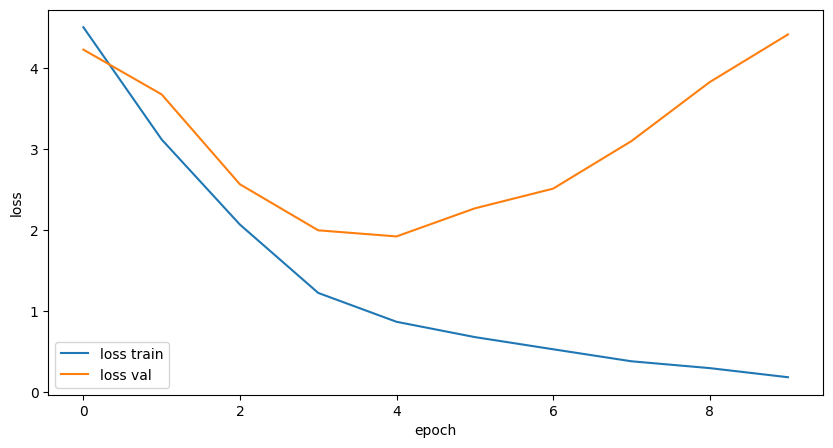

In [77]:
# pickle load, do with cpu

# fig, axs = plt.subplots(nrows = 5, ncols = 2, figsize=(30, 20))
# axs = axs.flatten()
plt.figure(figsize = (10, 5))
for t in range(epoch_test):
    with open(f"/content/drive/MyDrive/sentiment/result/finetune_{smallLR}test{t}.pickle", "rb") as f:
        perform = pickle.load(f)

    loss_hist_train = perform["train_loss"]
    loss_hist_test = perform["val_loss"]
    print(loss_hist_test)
    plt.plot(loss_hist_train, label = "loss train")
    plt.plot(loss_hist_test, label = "loss val")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    break
plt.show()

###### Training

In [ ]:
gc.collect()
# //////////////////////////////////////////////////
# batch size : define in data section
config = {
    "epoch": 3,
    "smallLR": "smallLR",
    "lr": 0.005,
    "weight_decay": 0.001,
    "num_warmstep": 5000,
          }
smallLR = config["smallLR"]
if smallLR == "smallLR":
    config["lr"] = 0.005/np.ceil(len(merge_train)/batch_size)

####################################################################
# models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
senti_finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3).to(device)
optimizer = AdamW(senti_finbert.parameters(), lr = config["lr"], weight_decay = config["weight_decay"])
total_steps = len(merge_train) * config["epoch"]
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = config["num_warmstep"], num_training_steps = total_steps)

# ///////////////////////////////////////////////////////////////
# training
# counts:
# [n of positive, n of negative, n of neutral]
# returns_methods:
# [ret of buy all, ret of buy when pos, ret of buy when neg, ret of buy when neu]
senti_finbert, loss_hist_train, loss_hist_test, counts, returns_methods = training_finetune(
  data_train, data_val, senti_finbert, optimizer, scheduler, config)
####################################################################

####################################################################
# store, in val do not need. store in test section
# store for gpu
"""
file_name = f"finetune({smallLR})_友達220728to230428.pth"
model_path = f'/content/drive/MyDrive/sentiment/trained_model/{file_name}'
torch.save(senti_finbert.state_dict(), model_path)

# store for cpu
file_name = f"finetune({smallLR},cpu)_友達220728to230428.pth"
model_path = f'/content/drive/MyDrive/sentiment/trained_model/{file_name}'
torch.save(senti_finbert.to("cpu").state_dict(), model_path)
"""
####################################################################


####################################################################
# store result
perform = {}
perform["train_loss"] = loss_hist_train
perform["test_loss"] = loss_hist_test
perform["counts"] = counts
perform["returns_methods"] = returns_methods

with open(f"/content/drive/MyDrive/sentiment/result/finetune_{smallLR}test{t}.pickle", "wb") as f:
  pickle.dump(perform, f)
####################################################################


# load model/result
"""
file_name = "fintune(cpu)_友達_220728to230428.pth"
model_path = f'/content/drive/MyDrive/Sentiment/finetuned_model/{file_name}'
senti_finbert.load_state_dict(torch.load(model_path))
"""
with open(f"/content/drive/MyDrive/sentiment/result/finetune_{smallLR}test{t}.pickle", "rb") as f:
    d = pickle.load(f)

###### Plot

In [ ]:
# pickle load, do with cpu
import matplotlib.ticker as ticker
plt.figure(figsize = (10, 10))
plt.plot(loss_hist_train, label = "loss train")
plt.plot(loss_hist_test, label = "loss test")
plt.xlabel('Epoch')
plt.ylabel('Loss')
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.legend()
plt.show()

###### Check Backtest

In [ ]:
# Backtest in train_finetune function
# perform["returns_methods"]: Epoch 1, Epoch 2, Epoch3, ...
# [holding returns, buy when positive, neutral, negative]
perform["returns_methods"]

##### === Model add layer ===

###### Backtest Function

In [108]:
def backtest(test_result, upper, lower):
    output, returns, loss = test_result
    count_positive = 0
    count_negative = 0
    count_neutral = 0
    positive = torch.tensor([0.])
    negative = torch.tensor([0.])
    neutral = torch.tensor([0.])
    state = ""
    for (o_, r_) in zip(output, returns):
        if o_ >= upper:
            count_positive += 1
            positive += (r_ - 0.004) if state != "positive" else r_
            state = "positive"
        elif o_ <= lower:
            count_negative += 1
            negative += (r_ - 0.004) if state != "negative" else r_
            state = "negative"
        else:
            count_neutral += 1
            neutral += (r_ - 0.004) if state != "neutral" else r_
            state = "neutral"
    """
    print(f"N positive: {count_positive}; N neutral: {count_neutral}; N negative: {count_negative}")
    print(f"buy with predicted return >= 0.004: {positive}")
    print(f"buy with predicted return between +(-)0.004: {neutral}")
    print(f"buy with predicted return <= -0.004: {negative}")
    """
    returns_method = [np.array(returns.sum().reshape(1))[0], np.array(positive.reshape(1))[0],
                      np.array(neutral.reshape(1))[0], np.array(negative.reshape(1))[0]]
    counts = [count_positive, count_neutral, count_negative]
    return returns_method, counts

###### Model

In [109]:
# from Eng to tokens
# seperate whole tokens by 512, the limit of transformers, and add the result together for each part
# compute loss with labels, eg: tensor([1]), tensor([[ 6.0247, -8.2679, -4.6360]], grad_fn=<AddBackward0>)
# confirm working and training ok. while sometimes it won't train don't know why. maybe is lr??? to figure out
class Net(torch.nn.Module):

    def __init__(self, senti_finbert): # input_ids.shape[1]# , hd_size
        super(Net, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # self.linear_tobert = torch.nn.Linear(20, 512).to(device)
        # self.activation = torch.nn.functional.relu
        # self.norm1 = torch.nn.BatchNorm1d(in_size).to(device)
        self.linear2returns = torch.nn.Linear(3, 1).to(self.device)
        self.senti_finbert = senti_finbert

    def forward(self, input_ids, token_type_ids, attention_mask):
        x = self.senti_finbert(input_ids,
                              token_type_ids = token_type_ids,
                              attention_mask = attention_mask)
        x = self.linear2returns(x[0])
        return x

###### Train and Test Function

In [110]:
def training_addlayer(data_train, data_test, senti_finbert, optimizer, scheduler, lossf, config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    returns_methods = []
    counts = []
    loss_hist_train = []
    loss_hist_test = []
    for epoch in range(config["epoch"]):
        loss_sum = 0
        for index, batch in enumerate(data_train):
            # if index // 10 == 0:
            #     print("batch in epoch:", index)
            input_ids = batch[0].to(device)
            token_type_ids = batch[1].to(device)
            attention_mask = batch[2].to(device)
            ret_labels = batch[3].to(device)
            ret_num = batch[4].to(device)
            output = senti_finbert(input_ids, # add layer senti_finbert
                            token_type_ids = token_type_ids,
                            attention_mask = attention_mask)
            loss = lossf(output.to(torch.float32), ret_num.to(torch.float32))
            loss_sum += loss.detach().cpu()
            loss.backward()
            clip_grad_norm_(model.parameters(), 1.) # do this? prevent from gradient explode or deminish
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
        print(f"training loss EPOCH {epoch}: {loss_sum/(index + 1)}" )
        # test
        output_test, returns_test, test_loss = testing_addlayer(data_test, senti_finbert, lossf)
        test_results = (output_test, returns_test, test_loss)
        # backtest
        output_train, returns_train, loss = testing_addlayer(data_train, senti_finbert, lossf)
        lower, upper = np.percentile(np.array(output_train), 20), np.percentile(np.array(output_train), 80)
        returns_method, counts_period = backtest(test_results, upper, lower)

        loss_hist_train.append(loss_sum/(index + 1))
        loss_hist_test.append(test_loss)
        returns_methods.append(returns_method)
        counts.append(counts_period)
    return senti_finbert, loss_hist_train, loss_hist_test, counts, returns_methods

def testing_addlayer(data_test, FT_senti_finbert, lossf):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    output_test = torch.empty((0, 1))
    returns_test = torch.empty((0, 1))
    loss_sum = 0
    for index, batch in enumerate(data_test):
        # if index // 5 == 0:
        #     print("batch in epoch:", index)
        input_ids = batch[0].to(device)
        token_type_ids = batch[1].to(device)
        attention_mask = batch[2].to(device)
        ret_labels = batch[3].to(device)
        ret_num = batch[4].to(device)
        output = FT_senti_finbert(input_ids,
                        token_type_ids = token_type_ids,
                        attention_mask = attention_mask)
        loss = lossf(output.to(torch.float32), ret_num.to(torch.float32))
        loss_sum += loss.detach().cpu()
        output_test = torch.cat((output_test, output.detach().cpu()))
        returns_test = torch.cat((returns_test, ret_num.cpu()))
    print(f"test loss: {loss_sum/(index + 1)}")
    return output_test, returns_test, loss_sum/(index + 1)

###### Validation

In [ ]:
# ////////////////////////////////////////////////////////////
# Add layer
gc.collect()
config = {
    "epoch": 20,
    "smallLR": "smallLR",
    "lr": 0.005,
    "weight_decay": 0.001,
    "num_warmstep": 5000,
          }
smallLR = config["smallLR"]
if smallLR == "smallLR":
    config["lr"] = 0.005/np.ceil(len(merge_train)/batch_size)
# ////////////////////////////////////////////////////////////

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
senti_finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3).to(device)
# if want to load the finetuned bert to  add layer and train again run below
"""
file_name = "finbert_友達_220728to230428.pth"
model_path = f'/content/drive/MyDrive/Sentiment/finetuned_model/{file_name}'
senti_finbert.load_state_dict(torch.load(mdoel_path))
"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net(senti_finbert)
optimizer = AdamW(model.parameters(), lr = config["lr"], weight_decay = config["weight_decay"])
total_steps = len(merge_train) * config["epoch"]
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = config["num_warmstep"], num_training_steps = total_steps)
lossf = torch.nn.MSELoss()

# training
model, loss_hist_train, loss_hist_test, counts, returns_methods = training_addlayer(
    data_train, data_val, model, optimizer, scheduler, lossf, config)

# store
file_name = f"ADDlayer({smallLR})_友達220728to230428.pth"
model_path = f'/content/drive/MyDrive/sentiment/trained_model/{file_name}'
torch.save(model.state_dict(), model_path)

file_name = f"ADDlayer({smallLR},cpu)_友達220728to230428.pth"
model_path = f'/content/drive/MyDrive/sentiment/trained_model/{file_name}'
torch.save(model.to("cpu").state_dict(), model_path)


# load model
"""
file_name = "finbert(cpu)_友達_220728to230428.pth"
model_path = f'/content/drive/MyDrive/sentiment/finetuned_model/{file_name}'
senti_finbert.load_state_dict(torch.load(model_path))
"""
# store result
perform = {}
perform["train_loss"] = loss_hist_train
perform["test_loss"] = loss_hist_test
perform["counts"] = counts
perform["returns_methods"] = returns_methods

with open(f"/content/drive/MyDrive/sentiment/result/addlayer_{smallLR}.pickle", "wb") as f:
    pickle.dump(perform, f)

with open(f"/content/drive/MyDrive/sentiment/result/finetune_{smallLR}.pickle", "rb") as f:
    d = pickle.load(f)


###### Plot

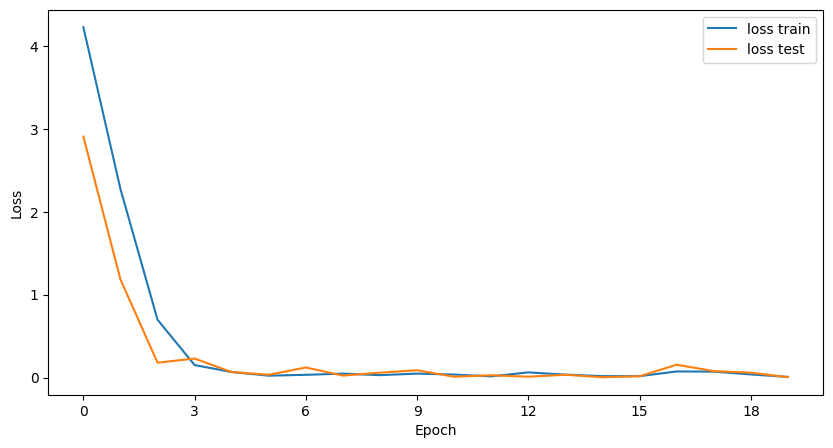

In [115]:
# pickle load, do with cpu
import matplotlib.ticker as ticker
plt.figure(figsize = (10, 5))
plt.plot(loss_hist_train, label = "loss train")
plt.plot(loss_hist_test, label = "loss test")
plt.xlabel('Epoch')
plt.ylabel('Loss')
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.legend()
plt.show()

###### Test

In [ ]:
# ////////////////////////////////////////////////////////////
# Add layer
gc.collect()
config = {
    "epoch": 6,
    "smallLR": "smallLR",
    "lr": 0.005,
    "weight_decay": 0.001,
    "num_warmstep": 5000,
          }
smallLR = config["smallLR"]
if smallLR == "smallLR":
    config["lr"] = 0.005/np.ceil(len(merge_train)/batch_size)
# ////////////////////////////////////////////////////////////

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
senti_finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3).to(device)
# if want to load the finetuned bert to  add layer and train again run below
"""
file_name = "finbert_友達_220728to230428.pth"
model_path = f'/content/drive/MyDrive/sentiment/finetuned_model/{file_name}'
senti_finbert.load_state_dict(torch.load(mdoel_path))
"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net(senti_finbert)
optimizer = AdamW(model.parameters(), lr = config["lr"], weight_decay = config["weight_decay"])
total_steps = len(merge_train) * config["epoch"]
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = config["num_warmstep"], num_training_steps = total_steps)
lossf = torch.nn.MSELoss()

# training
model, loss_hist_train, loss_hist_test, counts, returns_methods = training_addlayer(
    data_train, data_test, model, optimizer, scheduler, lossf, config)

# store
file_name = f"ADDlayer({smallLR})_友達220728to230428.pth"
model_path = f'/content/drive/MyDrive/sentiment/trained_model/{file_name}'
torch.save(model.state_dict(), model_path)

file_name = f"ADDlayer({smallLR},cpu)_友達220728to230428.pth"
model_path = f'/content/drive/MyDrive/sentiment/trained_model/{file_name}'
torch.save(model.to("cpu").state_dict(), model_path)


# load model
"""
file_name = "finbert(cpu)_友達_220728to230428.pth"
model_path = f'/content/drive/MyDrive/sentiment/finetuned_model/{file_name}'
senti_finbert.load_state_dict(torch.load(model_path))
"""
# store result
perform = {}
perform["train_loss"] = loss_hist_train
perform["test_loss"] = loss_hist_test
perform["counts"] = counts
perform["returns_methods"] = returns_methods

with open(f"/content/drive/MyDrive/sentiment/result/addlayer_{smallLR}.pickle", "wb") as f:
    pickle.dump(perform, f)

with open(f"/content/drive/MyDrive/sentiment/result/finetune_{smallLR}.pickle", "rb") as f:
    d = pickle.load(f)


###### Check Backtest

In [119]:
# Backtest in train_finetune function
# perform["returns_methods"]: Epoch 1, Epoch 2, Epoch3, ...
# [holding returns, buy when positive, neutral, negative]
perform["returns_methods"]

[[0.11328314749468767, -0.041862216, 0.10060953, -0.08546415],
 [0.11328314749468767, -0.059097882, 0.08451425, -0.080133244],
 [0.11328314749468767, -0.11575779, 0.0027167457, 0.06632419],
 [0.11328314749468767, -0.018909665, -0.100034885, 0.056227688],
 [0.11328314749468767, -0.04565102, -0.088319786, 0.06725395],
 [0.11328314749468767, -0.032883443, -0.10341147, 0.06557805],
 [0.11328314749468767, 0.025242254, -0.09156776, 0.015608649],
 [0.11328314749468767, -0.11767568, 0.1746059, -0.09964708],
 [0.11328314749468767, -0.008066489, -0.0043840506, -0.018266309],
 [0.11328314749468767, -0.018600872, 0.07097779, -0.09509379],
 [0.11328314749468767, -0.00029575394, -0.10554821, 0.051127102],
 [0.11328314749468767, -0.10001828, 0.046384763, -0.009083344],
 [0.11328314749468767, -0.104223326, 0.06255629, -0.009049829],
 [0.11328314749468767, -0.06586074, 0.004825651, 0.018318243],
 [0.11328314749468767, -0.11767002, 0.04691678, 0.028036386],
 [0.11328314749468767, -0.08310164, 0.09111611

[[0.11328314749468767, -0.041862216, 0.10060953, -0.08546415],
 [0.11328314749468767, -0.059097882, 0.08451425, -0.080133244],
 [0.11328314749468767, -0.11575779, 0.0027167457, 0.06632419],
 [0.11328314749468767, -0.018909665, -0.100034885, 0.056227688],
 [0.11328314749468767, -0.04565102, -0.088319786, 0.06725395],
 [0.11328314749468767, -0.032883443, -0.10341147, 0.06557805],
 [0.11328314749468767, 0.025242254, -0.09156776, 0.015608649],
 [0.11328314749468767, -0.11767568, 0.1746059, -0.09964708],
 [0.11328314749468767, -0.008066489, -0.0043840506, -0.018266309],
 [0.11328314749468767, -0.018600872, 0.07097779, -0.09509379],
 [0.11328314749468767, -0.00029575394, -0.10554821, 0.051127102],
 [0.11328314749468767, -0.10001828, 0.046384763, -0.009083344],
 [0.11328314749468767, -0.104223326, 0.06255629, -0.009049829],
 [0.11328314749468767, -0.06586074, 0.004825651, 0.018318243],
 [0.11328314749468767, -0.11767002, 0.04691678, 0.028036386],
 [0.11328314749468767, -0.08310164, 0.09111611

# LSTM-FINBERT

### Data

In [ ]:
def get_tokenizers(data_merge):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # get tokenizer for input_ids, token_type_ids, att_masks
    ret_num = torch.tensor(np.array(data_merge["return"])).reshape(-1, 1)
    ret_labels = torch.where(ret_num > 0.005, torch.tensor(1), torch.where(ret_num < -0.005, torch.tensor(2), torch.tensor(0)))
    senti_tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
    tokens = senti_tokenizer(data_merge["shorten_text"].to_list(), return_tensors="pt",
                              max_length=1024,
                              padding = True, truncation=True).to(device) # 0:index, 1:time, 2:title, 3:text

    input_ids = tokens["input_ids"] # 0
    token_type_ids = tokens["token_type_ids"] # 1
    att_masks = tokens["attention_mask"] # 2
    return input_ids, token_type_ids, att_masks, ret_num, ret_labels

def get_dataloader(data_df, returns, batch_size = 1):
    # padding and dataloader
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    data_merge = pd.merge(data_df, returns, on = "time", how = "left")
    input_ids, token_type_ids, att_masks, ret_num, ret_labels = get_tokenizers(data_merge)
    # print(input_ids.shape, ret_num.shape, token_type_ids.shape, att_masks.shape)

    data = TensorDataset(
        input_ids.to(device),
        token_type_ids.to(device),
        att_masks.to(device),
        ret_labels.to(device),
        ret_num.to(device))

    # Create the DataLoader for our training set.
    sampler = SequentialSampler(data)
    dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size)
    """
    print([i.shape[1] for i in input_ids])
    print([i.shape[1] for i in token_type_ids])
    print([i.shape[1] for i in att_masks])
    """
    return dataloader

# get data from words to tokenized dataloader
path = f"/content/drive/MyDrive/Sentiment/shortened_text/shortened_{media}_{keyword}.pickle"
data_all = pickle_load(path)

# train test split
data_train = data_all[(data_all["time"] >= from_date) & (data_all["time"] <= end_date)]
return_train = returns[(returns["time"] >= from_date) & (returns["time"] <= end_date)]
data_test = data_all[(data_all["time"] >= val_from_date) & (data_all["time"] <= val_end_date)]
return_test = returns[(returns["time"] >= val_from_date) & (returns["time"] <= val_end_date)]
batch_size = 1
data_train = get_dataloader(data_train, returns, batch_size = 5)
data_test = get_dataloader(data_test, returns, batch_size = 1)

### Model

In [ ]:
hidden = (torch.randn(1, 2, 3),
          torch.randn(1, , 3))
hidden[1].shape

torch.Size([1, 1, 3])

In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)
lstm = nn.LSTM(3, 3)  # 输入维度为3维，输出维度为3维
lstm = nn.LSTM(3, 42, 5, batch_first=True)
inputs = [torch.randn(6, 3) for _ in range(5)]  # 生成一个长度为5的序列

# 初始化隐藏状态.
hidden = (torch.randn(5, 1, 42),
          torch.randn(5, 1, 42))
for i in inputs:
    # 将序列中的元素逐个输入到LSTM.
    # 经过每步操作,hidden 的值包含了隐藏状态的信息.
    print(i.view(1, i.shape[0], i.shape[1]).shape)
    out, hidden = lstm(i.view(1, i.shape[0], i.shape[1]), hidden)
    print(out.shape)
    print(hidden[0].shape)
    break

torch.Size([1, 6, 3])
torch.Size([1, 6, 42])
torch.Size([5, 1, 42])


In [ ]:
gc.collect()

4179

In [ ]:
import torch.nn as nn
class lstm(nn.Module):
    def __init__(self, senti_finbert, input_size, hidden_size, num_layers, output_size):
        super(lstm, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.finbert = senti_finbert

    def forward(self, input_ids, token_type_ids, attention_mask):
        x = self.finbert(input_ids,
                              token_type_ids = token_type_ids,
                              attention_mask = attention_mask)
        h0 = torch.zeros(self.num_layers, input_ids.shape[0], self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, input_ids.shape[0], self.hidden_size).to(device)
        out, _ = self.lstm(x[0].view(1, x[0].shape[0], x[0].shape[1]), (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
senti_finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3).to(device)

input_size = 3
hidden_size = 6
num_layers = 3
output_size = 1
model = lstm(senti_finbert, input_size, hidden_size, num_layers, output_size)
for i, batch in enumerate(data_train):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_ids = batch[0].to(device)
    token_type_ids = batch[1].to(device)
    attention_mask = batch[2].to(device)
    ret_labels = batch[3].to(device)
    ret_num = batch[4].to(device)
    out = model(input_ids, token_type_ids, attention_mask)
    print(out)
    break

In [ ]:
a[0]

tensor([[ 5.0697, -4.7721, -2.7422],
        [ 0.8556,  0.1799, -4.1545],
        [ 0.1794, -3.2106,  4.0470],
        [-2.0179, -3.3628,  5.3450],
        [ 6.5229, -4.9477, -3.7289]], grad_fn=<AddmmBackward0>)

In [ ]:
import torch.nn as nn
class lstm(nn.Module):
    def __init__(self, senti_finbert, input_size, hidden_size, num_layers, output_size):
        super(lstm, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.finbert = senti_finbert

    def forward(self, x):
        x = self.finbert(input_ids,
                              token_type_ids = token_type_ids,
                              attention_mask = attention_mask)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
senti_finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3).to(device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size =  input_dimension  # Size of input features
hidden_size = lstm_hidden_size  # Number of LSTM units (hidden states)
num_layers = lstm_num_layers   # Number of LSTM layers
output_size = num_classes      # Number of classes for classification

model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 10

for epoch in range(num_epochs):
    for inputs, labels in dataloader:  # Iterate through your dataset
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
This is a basic outline of how to create an LSTM model using PyTorch's torch.nn.LSTM module. Remember to replace placeholders like input_dimension, lstm_hidden_size, lstm_num_layers, num_classes, learning_rate, and implement your own data loading pipeline using dataloader.







SyntaxError: ignored

In [ ]:
output, returns = backtest_finbert(data_test, finetune = True)
def backtesting(data_test, FT_senti_finbert, type_): # type: [finetune, add_layer]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    output_test = torch.empty((0, 3)) if type_ == "finetune" else  torch.empty((0, 1))
    returns_test = torch.empty((0, 1))
    loss_sum = 0
    for index, batch in enumerate(data_test):
        # if index // 5 == 0:
        #     print("batch in epoch:", index)
        input_ids = batch[0].to(device)
        token_type_ids = batch[1].to(device)
        attention_mask = batch[2].to(device)
        ret_labels = batch[3].to(device)
        ret_num = batch[4].to(device)
        if type_ == "finetune":
            output = FT_senti_finbert(input_ids,
                            token_type_ids = token_type_ids,
                            attention_mask = attention_mask,
                            labels = ret_labels.long())
            output = output[1]
        if type_ == "add_layer":
            output = FT_senti_finbert(input_ids,
                            token_type_ids = token_type_ids,
                            attention_mask = attention_mask)
        output_test = torch.cat((output_test, output.detach().cpu()))
        returns_test = torch.cat((returns_test, ret_num.cpu()))
    return output_test, returns_test, loss_sum/(index + 1)

In [ ]:
#### Not shorten func (newest)
def get_tokenizers(data_df, returns, device):
    # get tokenizer for input_ids, token_type_ids, att_masks
    senti_tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
    input_ids = []
    token_type_ids = []
    att_masks = []
    labels = []
    returns_num = []
    crossdate_text = ""
    state = "continuous"
    for index, i in data_df.reset_index().iterrows():
        print(i[1])
        tokens = senti_tokenizer(i[3], return_tensors="pt",
                                 max_length=max([len(l) for l in data_df["text"]]),
                                 padding = True, truncation=True).to(device) # 0:index, 1:time, 2:title, 3:text

        input_ids.append(tokens["input_ids"]) # 0
        token_type_ids.append(tokens["token_type_ids"]) # 1
        att_masks.append(tokens["attention_mask"]) # 2
        if returns["return"][returns["time"] == i[1]].values >= 0.005: # pos
            returns_label = torch.tensor(1)
        elif returns["return"][returns["time"] == i[1]].values <= -0.005: # neg
            returns_label = torch.tensor(2)
        else: # neu
            returns_label = torch.tensor(0)
        labels.append(returns_label)
        returns_num.append(torch.tensor(returns["return"][returns["time"] == i[1]].values))
    return input_ids, token_type_ids, att_masks, labels, returns_num

def get_dataloader(data_df, returns, from_date, end_date, path, batch_size = 1):
    # padding and dataloader
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    data_df = data_df[(data_df["time"] >= from_date) & (data_df['time'] <= end_date)]
    input_ids, token_type_ids, att_masks, labels, returns_num = get_tokenizers(data_df, returns, device)
    max_inputs = max([i.shape[1] for i in input_ids])
    max_tokens = max([i.shape[1] for i in token_type_ids])
    max_atts = max([i.shape[1] for i in att_masks])
    input_ids = [torch.nn.functional.pad(i, (0,max_inputs - i.shape[1])) for i in input_ids]
    token_type_ids = [torch.nn.functional.pad(i, (0, max_tokens - i.shape[1])) for i in token_type_ids]
    att_masks = [torch.nn.functional.pad(i, (0, max_atts - i.shape[1])) for i in att_masks]
    # print(torch.stack(input_ids).squeeze(1).to(device), token_type_ids, att_masks)

    data = TensorDataset(
        torch.stack(input_ids).squeeze(1).to(device),
        torch.stack(token_type_ids).squeeze(1).to(device),
        torch.stack(att_masks).squeeze(1).to(device),
        torch.stack(labels).to(device),
        torch.stack(returns_num).to(device))

    # Create the DataLoader for our training set.
    sampler = SequentialSampler(data)
    dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size)
    """
    print([i.shape[1] for i in input_ids])
    print([i.shape[1] for i in token_type_ids])
    print([i.shape[1] for i in att_masks])
    """
    return dataloader

# from Eng to tokens
# seperate whole tokens by 512, the limit of transformers, and add the result together for each part
# compute loss with labels, eg: tensor([1]), tensor([[ 6.0247, -8.2679, -4.6360]], grad_fn=<AddBackward0>)
# confirm working and training ok. while sometimes it won't train don't know why. maybe is lr??? to figure out
class Net(torch.nn.Module):

    def __init__(self, in_size): # input_ids.shape[1]# , hd_size
        super(Net, self).__init__()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.linear_tobert = torch.nn.Linear(in_size, 512).to(device)
        self.activation = torch.nn.functional.relu
        self.norm1 = torch.nn.BatchNorm1d(in_size).to(device)

    def forward(self, input_ids, token_type_ids, attention_masks, labels):
        # positional encoding?
        scores =  torch.zeros([input_ids.shape[0], 3], dtype = torch.float32).to(device)
        for k, i in enumerate(range(input_ids.shape[1]//512)):
            part_input_ids = input_ids[:, i*512:(i+1)*512]
            part_token_type_ids = token_type_ids[:, i*512:(i+1)*512]
            part_att_masks = attention_masks[:, i*512:(i+1)*512]
            # print(part_input_ids, part_token_type_ids, part_att_masks)
            x = senti_finbert(part_input_ids,
                              token_type_ids = part_token_type_ids,
                              attention_mask = part_att_masks)
            scores += x[0]
            if k >= 2:
                break
        return scores

In [ ]:
# working codes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
senti_finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3).to(device)
optimizer = AdamW(senti_finbert.parameters(), lr = config["lr"], weight_decay = config["weight_d"])
epoch = config["epoch"]
total_steps = len(data) * epoch
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = config["num_warmstep"], num_training_steps = total_steps)

for i in range(epoch):
    loss = 0
    for index, batch in enumerate(data):
        gc.collect()
        for i in range(input_ids.shape[1]//512)
        input_ids = torch.tensor(batch[0][:, :512]).to(device) # , dtype = torch.float32
        token_type_ids = torch.tensor(batch[1][:, :512]).to(device)
        att_masks = torch.tensor(batch[2][:, :512]).to(device)
        labels = torch.tensor(batch[3]).to(device)
        returns_num = batch[4].to(device)
        output = senti_finbert(input_ids,
                                     token_type_ids = token_type_ids,
                                     attention_mask = att_masks,
                                     labels = labels.long())
        print(labels, output)
        loss = output[0]
        loss.backward()
        # clip_grad_norm_(senti_finbert.parameters(), 1.)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        loss += loss
    print(loss)


"""
        input_ids = torch.tensor(self.linear_tobert(torch.tensor(input_ids, dtype = torch.float32)), dtype =  torch.int).to(device) # , dtype = torch.float32
        token_type_ids = torch.tensor(self.linear_tobert(torch.tensor(token_type_ids, dtype = torch.float32)), dtype =  torch.int).to(device)
        attention_mask = torch.tensor(self.linear_tobert(torch.tensor(attention_mask, dtype = torch.float32)), dtype =  torch.int).to(device)
"""

In [ ]:
config = {
    "epcoh": 10,
    "lr": 1,
    "weight_d": 0.00,
    "num_warmstep": 5000, # 10000
          }
senti_finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3).to(device)
optimizer = AdamW(senti_finbert.parameters(), lr = config["lr"], weight_decay = config["weight_d"])
epoch = config["epcoh"]
total_steps = len(data) * epoch
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = config["num_warmstep"], num_training_steps = total_steps)

for i in range(epoch):
    for index, batch in enumerate(data):
        b_input_id = batch[0][:, :512].to(device)
        b_token_type_id = batch[1][:, :512].to(device)
        b_att_mask = batch[2][:, :512].to(device)
        b_labels = batch[3].to(device)
        # senti_finbert.zero_grad()
        output = senti_finbert(input_ids = b_input_id, token_type_ids = b_token_type_id, attention_mask = b_att_mask, labels = b_labels)
        loss, logits = output[0], output[1]
        loss.backward()
        clip_grad_norm_(senti_finbert.parameters(), 1.)
        optimizer.step()
        scheduler.step()
        print(logits)
        #print(b_input_id.shape)
        #print(b_token_type_id.shape)
        #print(b_att_mask.shape)
        #print(b_labels.shape)

"""
class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        return self.data[index]
"""

tensor([[ 1.4937, -2.6720, -0.6041],
        [ 7.3032, -3.0453, -6.8335],
        [ 4.5546, -0.7754, -6.1829],
        [-0.8579, -2.5491,  4.7933]], grad_fn=<AddmmBackward0>)
tensor([[ 1.4937, -2.6720, -0.6041],
        [ 7.3032, -3.0453, -6.8335],
        [ 4.5546, -0.7754, -6.1829],
        [-0.8579, -2.5491,  4.7933]], grad_fn=<AddmmBackward0>)


KeyboardInterrupt: ignored